In [1]:
from src.datasets.crack_loader import CrackLoader
import numpy as np
import torchvision.transforms as T
import matplotlib.pyplot as plt
from utils import set_seed
from src.nets.lenet import LeNet5
import seaborn as sns
from src.nets.swag import SWAG
import torch

DATA_DIR = './data/crack'

set_seed(0)

INFO:numexpr.utils:Note: NumExpr detected 14 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


In [2]:
def compute_uncertainties(probs, eps = 1e-12):
    # T: num MC passes
    # B: batch size
    # C: num classes

    T = probs.shape[0]
    probs = np.clip(probs, eps, 1 - eps)

    probs_mean = np.mean(probs, axis=0) # (B, C) 
    
    total_unc = -np.sum(probs_mean * np.log(probs_mean + eps), axis=1) # (B,) 
    ale_unc = np.mean(-np.sum(probs * np.log(probs + eps), axis=2), axis=0) # (B,)
    epi_unc = total_unc - ale_unc

    return total_unc, ale_unc, epi_unc

def total_uncertainty(out_probs, eps=1e-12):
    # out_probs shape: [M x N x 2]
    # M: num models
    # N: num samples
    # 2: num classes

    # TU = H(p_mean(y)), p_mean(y): average predictive probabilities over M models

    pmean = np.mean(out_probs, axis=0) # N x 2
    return -np.sum(pmean * np.log(pmean + eps), axis=1) # N

def aleatoric_uncertainty(out_probs, eps=1e-12):
    # out_probs shape: [M x N x 2]
    # M: num models
    # N: num samples
    # 2: num classes

    # AU = mean(H(p_m(y))), p_m(y): predictive probabilities for model m

    entropy_pm = -np.sum(out_probs * np.log(out_probs + eps), axis=-1) # M x N
    return np.mean(entropy_pm, axis=0) # N

## Load dataset
We start by constructing a *dataloader* for the dataset of interest. The labels will be:
- $0$: cracked
- $1$: uncracked
We proceed with a quick visualization for the data of interest

In [3]:
dataset = CrackLoader(data_dir=DATA_DIR, normalize=True)
print(f'Train [80%]: {dataset.train_size}x3x120x120')
print(f'Validation [20%]: {dataset.val_size}x3x120x120')

INFO:root:Loading crack dataset


Train [80%]: 11974x3x120x120
Validation [20%]: 2994x3x120x120


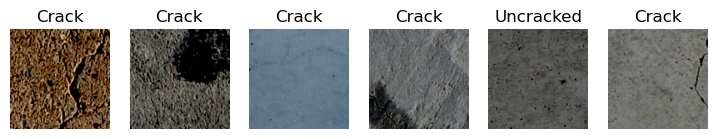

In [4]:
data_iter = iter(dataset.train_loader)
images, labels = next(data_iter)
images = images[:6].cpu()
labels = labels[:6]
    
fig, axs = plt.subplots(1,6,figsize=(9, 3))
for i in range(6):
    img = images[i].permute(1, 2, 0)
    axs[i].imshow(img.squeeze())
    axs[i].set_title('Crack' if labels[i] == 0 else 'Uncracked')
    axs[i].axis('off')
plt.show()

## Import pre-trained model

We first analyze a model trained with naive optimization. The setup is:
- Optimizer: SGD (learning_rate = 1e-3, momentum = 0.09, weight_decay = 5e-4)
- Epochs: 30

In [5]:
model = torch.load('./experiments/models/lenet5-optim.pt', weights_only=False)
results = np.load('./experiments/results/lenet5-optim.npz')
sns.lineplot(results['train_accuracy_progress'])
sns.lineplot(results['valid_accuracy_progress'])
np.argmax(results['predictions'], axis=-1)
results['true_labels'] == np.argmax(results['predictions'], axis=-1)

RuntimeError: Attempting to deserialize object on a CUDA device but torch.cuda.is_available() is False. If you are running on a CPU-only machine, please use torch.load with map_location=torch.device('cpu') to map your storages to the CPU.

In [6]:
model = torch.load('./experiments/models/lenet5-swag.pt', weights_only=False, map_location=torch.device('cpu'))
results = np.load('./experiments/results/lenet5-swag.npz')
output_probs = results['predictions']
true_labels = results['true_labels']
tu = total_uncertainty(output_probs)
au = aleatoric_uncertainty(output_probs), 
eu = tu - au
print("TU = {:.4f} +- {:.4f}".format(np.mean(tu), np.std(tu)))
print("AU = {:.4f} +- {:.4f}".format(np.mean(au), np.std(au)))
print("EU = {:.4f} +- {:.4f}".format(np.mean(eu), np.std(eu)))

TU = 0.6410 +- 0.0688
AU = 0.6004 +- 0.0745
EU = 0.0406 +- 0.0183


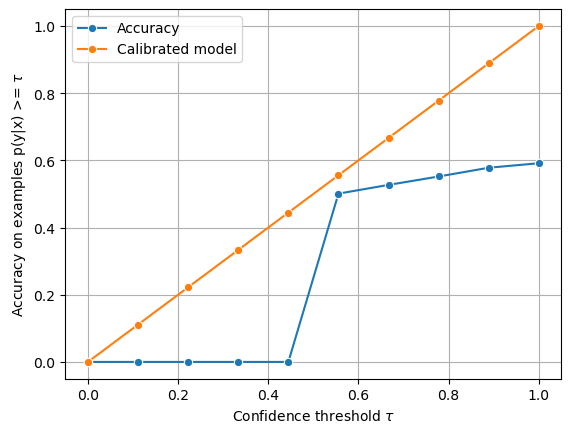

In [10]:
output_probs_max_val = np.max(output_probs, axis=-1)  # M x N
output_probs_max_class = np.argmax(output_probs, axis=-1)  # M x N

tr = np.linspace(0, 1, 10)
M, N, _ = output_probs.shape
accuracies = np.zeros((len(tr), M))
num_labels = np.zeros((len(tr), M))

for i, threshold in enumerate(tr):
    for m in range(M):
        # Get boolean mask for samples with probability > threshold
        mask = output_probs_max_val[m] < threshold  # N 

        # Mask predictions
        valid_preds = output_probs_max_class[m][mask] 
        valid_labels = true_labels[mask]

        # Compute accuracy for valid predictions
        if len(valid_labels) > 0:
            accuracies[i, m] = np.mean(valid_preds == valid_labels)
        else:
            accuracies[i, m] = 0
        num_labels[i, m] = len(valid_labels)

accuracies_avg_models = np.mean(accuracies, axis=1)
num_labels_avg_models = np.mean(num_labels, axis=1)

sns.lineplot(x=tr, y=accuracies_avg_models, marker='o', label='Accuracy')
sns.lineplot(x=tr, y=tr, marker='o', label='Calibrated model')
plt.xlabel(r'Confidence threshold $\tau$')
plt.ylabel(r'Accuracy on examples p(y|x) >= $\tau$')
plt.grid(True)
plt.show()